In [2]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

# QSVT in Practice

::: meta
:property=\"og:description\": Quantum Singular Value Transformation
algorithm :property=\"og:image\":
<https://pennylane.ai/qml/_static/demonstration_assets/thumbnail_intro_qsvt.png>
:::

::: related
tutorial_intro_qsvt Intro to QSVT function_fitting_qsp Function Fitting
using Quantum Signal Processing
:::

*Authors: Jay Soni, Jarrett Smalley \[Rolls-Royce\] --- Posted: 22
August 2023.*

The Quantum Singular Value Transformation (QSVT) is a quantum algorithm
that allows us to apply arbitrary polynomial transformations to the
singular values of a matrix. This demo, written in collaboration between
Xanadu and Rolls-Royce, provides a practical guide for the QSVT
functionality in PennyLane, by solving a linear system of equations
(LSE) as a guiding example.

| 

![](../_static/demonstration_assets/apply_qsvt/thumbnail_tutorial_QSVT_for_Matrix_Inversion.png){.align-center
width="50.0%"}

| 

## Preliminaries

For a refresher on the basics of QSVT check out our
`Intro to QSVT </demos/tutorial_intro_qsvt>`{.interpreted-text
role="doc"} tutorial. Let\'s recall how to apply QSVT in a circuit. This
requires two pieces of information as input: the block encoding of the
matrix to be transformed and a set of projectors which determine the
polynomial transformation. For now, we use placeholder values for the
phase angles; we\'ll later describe how to obtain them. The code below
shows how to construct a basic QSVT circuit on two qubits:


In [15]:
import pennylane as qml
from pennylane import numpy as np

dev = qml.device("lightning.qubit", wires=[0, 1])

A = np.array([[0.1, 0.2], [0.3, 0.4]])
phase_angles = np.array([0.0, 1.0, 2.0, 3.0])

block_encoding = qml.BlockEncode(A, wires=[0, 1])
projectors = [qml.PCPhase(angle, dim=2, wires=[0, 1]) for angle in phase_angles]


@qml.qnode(dev)
def my_circuit():
    qml.QSVT(block_encoding, projectors)
    return qml.state()

We can now execute the circuit and visualize it.


In [16]:
my_circuit()
print(qml.draw(my_circuit, level="top")())

0: ─╭QSVT─┤  State
1: ─╰QSVT─┤  State


We can inspect details by drawing the expanded circuit. The
`~.pennylane.QSVT`{.interpreted-text role="class"} operation is composed
of repeated applications of the
`~.pennylane.BlockEncode`{.interpreted-text role="class"} and
`~.pennylane.PCPhase`{.interpreted-text role="class"} ($\Pi_{\phi}$)
operations.


In [17]:
print(qml.draw(my_circuit)())

0: ─╭∏_ϕ(0.00)─╭BlockEncode(M0)─╭∏_ϕ(1.00)─╭BlockEncode(M0)†─╭∏_ϕ(2.00)─╭BlockEncode(M0)─╭∏_ϕ(3.00)─┤
1: ─╰∏_ϕ(0.00)─╰BlockEncode(M0)─╰∏_ϕ(1.00)─╰BlockEncode(M0)†─╰∏_ϕ(2.00)─╰BlockEncode(M0)─╰∏_ϕ(3.00)─┤

   State
   State

M0 = 
[[0.1 0.2]
 [0.3 0.4]]


[PolyTaylorSeries] (Cheb) max 0.999998852140228 is at -0.15708092445480415: normalizing
[PolyTaylorSeries] (Cheb) average error = 2.6652247823660913e-06 in the domain [-1, 1] using degree 20
[sym_qsp] Iterative optimization to err 1.000e-12 or max_iter 100.
iter: 001 --- err: 1.175e-01
iter: 002 --- err: 4.249e-03
iter: 003 --- err: 6.911e-06
iter: 004 --- err: 2.049e-11
iter: 005 --- err: 5.469e-16
[sym_qsp] Stop criteria satisfied.


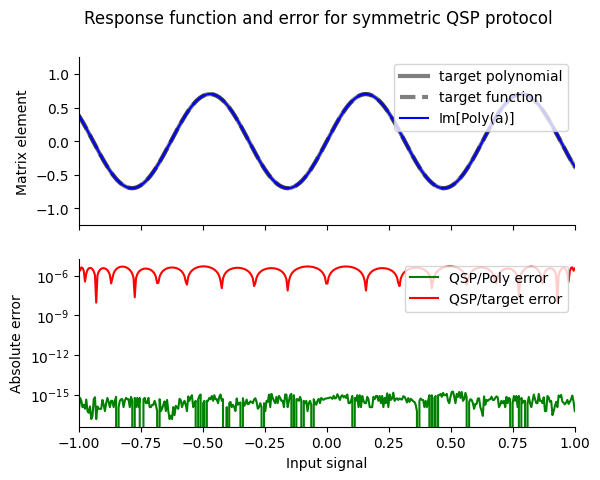

In [14]:
import numpy as np
import pyqsp
from pyqsp import angle_sequence, response
from pyqsp.poly import polynomial_generators, PolyTaylorSeries

"""
The python package pyqsp allows you to generate new angle sequences: https://github.com/ichuang/pyqsp

The sample code under "A guide within a guide" is the most efficient way to get started.
However, for use in the QSVT algorithm, 'phiset' as output by the sample code: 

(phiset, red_phiset, parity) = angle_sequence.QuantumSignalProcessingPhases(
    poly,
    method='sym_qsp',
    chebyshev_basis=True)

must be slightly modified. The function QSVT_format below implements the required
modification. 
"""


def QSVT_format(phiset):
    n = len(phiset) - 1
    Phi = np.zeros(n)
    Phi[1:n] = phiset[1:n] - np.pi / 2
    Phi[0] = phiset[0] + phiset[-1] + ((n - 2) % 4) * np.pi / 2
    # If you use output from the MATLAB package qsppack you have to replace (n-2) by (n-1) in the above formula!
    return Phi


def QSVT_cosinus(degree_cutoff: int, max_scale: float, M_step: int):
    func = lambda x: max_scale * np.cos(M_step * x)

    poly = PolyTaylorSeries().taylor_series(
        func=func, degree=degree_cutoff, max_scale=max_scale, chebyshev_basis=True, cheb_samples=2 * degree_cutoff
    )

    angles, reduced_angles, parity = angle_sequence.QuantumSignalProcessingPhases(
        poly, method="sym_qsp", chebyshev_basis=True
    )

    return angles, poly


def QSVT_sinus(degree_cutoff: int, max_scale: float, M_step: int):
    func = lambda x: max_scale * np.sin(M_step * x)

    poly = PolyTaylorSeries().taylor_series(
        func=func, degree=degree_cutoff, max_scale=max_scale, chebyshev_basis=True, cheb_samples=2 * degree_cutoff
    )

    angles, reduced_angles, parity = angle_sequence.QuantumSignalProcessingPhases(
        poly, method="sym_qsp", chebyshev_basis=True
    )

    return angles, poly


M_step = 10
max_scale = 0.7
true_func = lambda x: max_scale * np.sin(M_step * x)


ang, poly = QSVT_sinus(20, max_scale, M_step)


response.PlotQSPResponse(ang, pcoefs=poly, target=true_func, sym_qsp=True, simul_error_plot=True)

Now let\'s look at an application of QSVT \-\-- solving a linear system
of equations.

# Problem

The most convenient way to represent a linear system of equations is as
a matrix vector problem. Given a matrix $A$ and a vector $\vec{b},$ we
want to solve $A \cdot \vec{x} = \vec{b}.$ This ultimately requires
computing $\vec{x} = A^{-1} \cdot \vec{b},$ where for simplicity we
assume that $A$ is invertible.

$A^{-1}$ can be constructed directly by inverting the singular values of
$A^{T}.$ We can leverage QSVT to accomplish this by finding the phase
angles which apply a polynomial approximation to the transformation
$\frac{1}{x}.$ This may seem simple in theory, but in practice there are
a few technical details that need to be addressed.

First, it is difficult to approximate $\frac{1}{x}$ close to $x=0.$ This
leads to large degree polynomials and very deep quantum circuits.
However, it turns out that we only need a good approximation up to the
smallest singular value of the target matrix. We introduce the parameter
$\kappa$ that defines the domain $[\frac{1}{\kappa}, 1]$ for which the
approximation should be good.

Second, the QSVT algorithm produces polynomials which are bounded in
magnitude by one on the domain $x \in [-1, 1].$ However, $\frac{1}{x}$
falls outside the bounds on this domain. To remedy this, we introduce a
scale factor $s$ and approximate $s \cdot \frac{1}{x}.$

# Obtaining Phase Angles

The QSVT phase angles $\vec{\phi}$ define the polynomial transformation.
Here we describe two approaches to obtain the phase angles:

1.  Using external packages that provide numerical angle solvers
    ([pyqsp](https://github.com/ichuang/pyqsp)).
2.  Using PennyLane\'s differentiable workflow to optimize the phase
    angles.

Let\'s use both methods to apply a polynomial transformation that
approximates

$$P(x) = s \cdot \frac{1}{x}.$$

## Phase Angles from PyQSP

There are many numerical methods for computing the phase angles (see ,).
They can be readily used with PennyLane as long as the convention used
to define the rotations matches the one used when applying QSVT. This is
as simple as specifying the convention as a keyword argument to the
`~.pennylane.qsvt()`{.interpreted-text role="func"} function. We
demonstrate this by obtaining angles using the
[pyqsp](https://github.com/ichuang/pyqsp) library.

The phase angles generated from pyqsp are presented below. A value of
$\kappa=4$ was used and the scale factor was extracted from the pyqsp
module. Remember that the number of phase angles determines the degree
of the polynomial approximation. Below we display the 44 angles which
produce a polynomial of degree 43.


In [18]:
kappa = 4
s = 0.10145775
phi_pyqsp = [
    -2.287,
    2.776,
    -1.163,
    0.408,
    -0.16,
    -0.387,
    0.385,
    -0.726,
    0.456,
    0.062,
    -0.468,
    0.393,
    0.028,
    -0.567,
    0.76,
    -0.432,
    -0.011,
    0.323,
    -0.573,
    0.82,
    -1.096,
    1.407,
    -1.735,
    2.046,
    -2.321,
    2.569,
    -2.819,
    -0.011,
    2.71,
    -2.382,
    2.574,
    0.028,
    -2.749,
    2.673,
    0.062,
    -2.685,
    2.416,
    0.385,
    -0.387,
    -0.16,
    0.408,
    -1.163,
    -0.365,
    2.426,
]
# phi_qsvt = qml.transform_angles(phi_pyqsp, "QSP", "QSVT")  # convert pyqsp angles to be compatible with QSVT
phi_qsvt = qml.transform_angles(phi_pyqsp, "QSP", "QSVT")  # convert pyqsp angles to be compatible with QSVT

::: note
::: title
Note
:::

We generated the angles using the following pyqsp functions. These
methods have a randomized component which results in slightly different
phase angles each time producing the same transformation:

``` bash
>>> pcoefs, s = pyqsp.poly.PolyOneOverX().generate(kappa, return_coef=True, ensure_bounded=True, return_scale=True)
>>> phi_pyqsp = pyqsp.angle_sequence.QuantumSignalProcessingPhases(pcoefs, signal_operator="Wx", tolerance=0.00001)
```
:::

Let\'s confirm that these angles perform the correct transformation. We
use the `~.pennylane.matrix()`{.interpreted-text role="func"} function
to obtain the output matrix of the QSVT circuit. The top-left entry is a
polynomial approximation whose real component corresponds to our target
function $P(x).$


In [19]:
x_vals = np.linspace(0, 1, 50)
target_y_vals = [true_func(x) for x in np.linspace(s, 1, 50)]

qsvt_y_vals = []
for x in x_vals:

    block_encoding = qml.BlockEncode(x, wires=[0])
    projectors = [qml.PCPhase(angle, dim=1, wires=[0]) for angle in phi_qsvt]

    poly_x = qml.matrix(qml.QSVT, wire_order=[0])(block_encoding, projectors)
    qsvt_y_vals.append(np.real(poly_x[0, 0]))

We plot the target function and our approximation generated from QSVT.


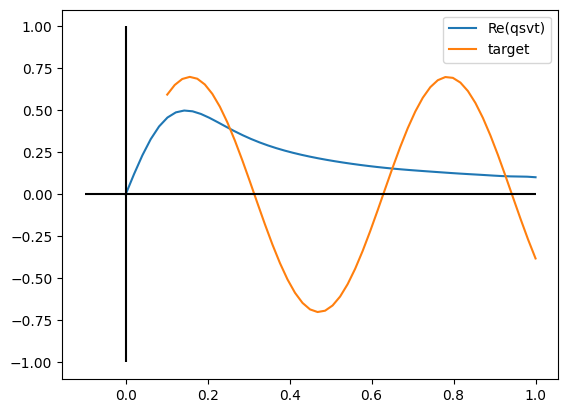

In [20]:
import matplotlib.pyplot as plt

plt.plot(x_vals, np.array(qsvt_y_vals), label="Re(qsvt)")
plt.plot(np.linspace(s, 1, 50), target_y_vals, label="target")

# plt.vlines(1 / kappa, -1.0, 1.0, linestyle="--", color="grey", label="1/kappa")
plt.vlines(0.0, -1.0, 1.0, color="black")
plt.hlines(0.0, -0.1, 1.0, color="black")

plt.legend()
plt.show()

Yay! We were able to get an approximation of the function
$s \cdot \frac{1}{x}$ on the domain $[\frac{1}{\kappa}, 1].$

# Phase Angles from Optimization

The QSVT operation, like all other operations in PennyLane, is fully
differentiable. We can take advantage of this as an alternate approach
to obtaining the phase angles by using gradient-based optimization. This
method is very versatile because we can use the target function directly
to generate a polynomial approximation from QSVT.

A single QSVT circuit will produce a transformation that has a fixed
parity. We can be clever and get a better approximation by using a sum
of an even and odd polynomial. This is achieved by using a simple linear
combination of unitaries ([LCU](https://codebook.xanadu.ai/H.6)). We
first split the phase angles into two groups (even and odd parity).
Next, an ancilla qubit is prepared in equal superposition. We apply each
QSVT operation, even or odd, conditioned on the ancilla. Finally, the
ancilla qubit is reset.


In [21]:
def sum_even_odd_circ(x, phi, ancilla_wire, wires):
    phi1, phi2 = phi[: len(phi) // 2], phi[len(phi) // 2 :]
    block_encode = qml.BlockEncode(x, wires=wires)

    qml.Hadamard(wires=ancilla_wire)  # equal superposition

    # apply even and odd polynomial approx

    dim = x.shape[0] if x.ndim > 0 else 1
    projectors_even = [qml.PCPhase(angle, dim=dim, wires=wires) for angle in phi1]
    qml.ctrl(qml.QSVT, control=(ancilla_wire,), control_values=(0,))(block_encode, projectors_even)

    projectors_odd = [qml.PCPhase(angle, dim=dim, wires=wires) for angle in phi2]
    qml.ctrl(qml.QSVT, control=(ancilla_wire,), control_values=(0,))(block_encode, projectors_odd)

    qml.Hadamard(wires=ancilla_wire)  # un-prepare superposition

We now randomly initialize a total of 51 phase angles. This implies that
the resulting transformation will be a sum of polynomials with degrees
25 and 26, respectively.


In [22]:
np.random.seed(42)  # set seed for reproducibility
phi = np.random.rand(51)

Next, we select a mean-squared error (MSE) loss function. The error is
computed using samples from the domain $[\frac{1}{\kappa}, 1]$ where the
target function is defined. Since the polynomial produced by the QSVT
circuit is complex valued, we compare its real value against our target
function. We ignore the imaginary component for now.


In [23]:
samples_x = np.linspace(1 / kappa, 1, 100)


def target_func(x):
    return np.sin(M_step * x)


def loss_func(phi):
    sum_square_error = 0
    for x in samples_x:
        qsvt_matrix = qml.matrix(sum_even_odd_circ, wire_order=["ancilla", 0])(
            x, phi, ancilla_wire="ancilla", wires=[0]
        )
        qsvt_val = qsvt_matrix[0, 0]
        sum_square_error += (np.real(qsvt_val) - target_func(x)) ** 2

    return sum_square_error / len(samples_x)

Thanks to PennyLane\'s fully differentiable workflow, we can execute the
optimization in just a few lines of code:


In [24]:
# Optimization:
cost = 1
iter = 0
opt = qml.AdagradOptimizer(0.1)

while cost > 0.5e-4:
    iter += 1
    phi, cost = opt.step_and_cost(loss_func, phi)

    if iter % 10 == 0 or iter == 1:
        print(f"iter: {iter}, cost: {cost}")

    if iter > 100:
        print("Iteration limit reached!")
        break

print(f"Completed Optimization! (final cost: {cost})")

iter: 1, cost: 1.0397659725486654
iter: 10, cost: 0.24718302198908476
iter: 20, cost: 0.23503953780777628
iter: 30, cost: 0.23342153198525065
iter: 40, cost: 0.23238810805428112
iter: 50, cost: 0.2316583274054882
iter: 60, cost: 0.23110443799591976
iter: 70, cost: 0.2306600498634049
iter: 80, cost: 0.23028799897938362
iter: 90, cost: 0.22996639282760012
iter: 100, cost: 0.22968178206938034
Iteration limit reached!
Completed Optimization! (final cost: 0.2296549947492608)


Now we plot the results:


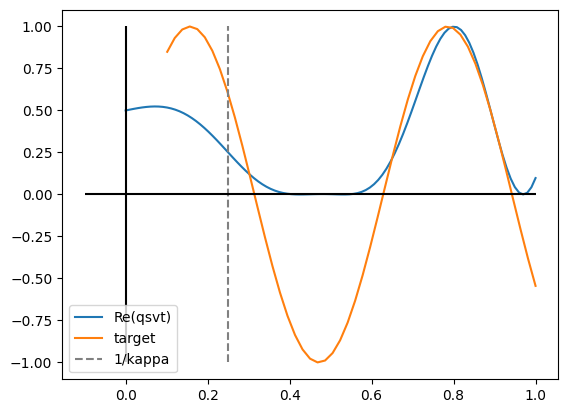

In [26]:
samples_inv = np.linspace(s, 1, 50)
inv_x = [target_func(x) for x in samples_inv]

samples_x = np.linspace(0, 1, 100)
qsvt_y_vals = [
    np.real(qml.matrix(sum_even_odd_circ, wire_order=["ancilla", 0])(x, phi, "ancilla", wires=[0])[0, 0])
    for x in samples_x
]

plt.plot(samples_x, qsvt_y_vals, label="Re(qsvt)")
plt.plot(samples_inv, inv_x, label="target")

plt.vlines(1 / kappa, -1.0, 1.0, linestyle="--", color="grey", label="1/kappa")
plt.vlines(0.0, -1.0, 1.0, color="black")
plt.hlines(0.0, -0.1, 1.0, color="black")

plt.legend()
plt.show()

Awesome, we successfully optimized the phase angles! While we used a
simple loss function and optimizer, more sophisticated optimization
schemes have been presented in literature to robustly train the phase
angles for QSVT (see).

Let $\hat{U}_{qsvt}(\vec{\phi}, x)$ represent the unitary matrix of the
QSVT algorithm. Both of the methods above produce phase angles
$\vec{\phi}$ such that:

$$Re[\hat{U}_{qsvt}(\vec{\phi}, x)] \approx P(x).$$

In general, the imaginary part of this transformation will not be zero.
We need an operator which only applies the real component. Note that we
can express the real part of a complex number $z$ as
$Re[z] = \frac{1}{2}(z + z^{*}).$ Similarly, for operators this is given
by:

$$\hat{U}_{real}(\vec{\phi}) = \frac{1}{2} \ ( \hat{U}_{qsvt}(\vec{\phi}) + \hat{U}^{*}_{qsvt}(\vec{\phi}) ).$$

Here we use a two-term LCU to define the quantum function for this
operator. We obtain the complex conjugate of $\hat{U}_{qsvt}$ by taking
the adjoint of the operator block-encoding $A^{T}:$


In [ ]:
def real_u(A, phi):
    qml.Hadamard(wires="ancilla1")

    qml.ctrl(sum_even_odd_circ, control=("ancilla1",), control_values=(0,))(A, phi, "ancilla2", [0, 1, 2])
    qml.ctrl(qml.adjoint(sum_even_odd_circ), control=("ancilla1",), control_values=(1,))(
        A.T, phi, "ancilla2", [0, 1, 2]
    )

    qml.Hadamard(wires="ancilla1")

Let\'s take everything we have learned and apply it to solve a linear
system of equations.

# Solving a Linear System with QSVT

Our goal is to solve the equation $A \cdot \vec{x} = \vec{b}.$ This
method assumes the matrix we will invert is hermitian. Let\'s begin by
defining the specific matrix $A$ and vector $\vec{b}$ :


In [ ]:
A = np.array(
    [
        [0.65713691, -0.05349524, 0.08024556, -0.07242864],
        [-0.05349524, 0.65713691, -0.07242864, 0.08024556],
        [0.08024556, -0.07242864, 0.65713691, -0.05349524],
        [-0.07242864, 0.08024556, -0.05349524, 0.65713691],
    ]
)

b = np.array([1, 2, 3, 4], dtype="complex")
target_x = np.linalg.inv(A) @ b  # true solution

# Normalize states:
norm_b = np.linalg.norm(b)
normalized_b = b / norm_b

norm_x = np.linalg.norm(target_x)
normalized_x = target_x / norm_x

To solve the linear system we construct a quantum circuit that first
prepares the normalized vector $\vec{b}$ in the working qubit register.
Next we call the `real_u(A.T, phi)` function that we previously
constructed. This is equivalent to applying $s \cdot A^{-1}$ to the
prepared state. Finally, we return the state at the end of the circuit.

The subset of qubits which prepared the $\vec{b}$ vector should be
transformed to represent $\vec{x}$ (up to scaling factors):


In [ ]:
@qml.qnode(qml.device("default.qubit", wires=["ancilla1", "ancilla2", 0, 1, 2]))
def linear_system_solver_circuit(phi):
    qml.StatePrep(normalized_b, wires=[1, 2])
    real_u(A.T, phi)  # invert the singular values of A transpose to get A^-1
    return qml.state()


transformed_state = linear_system_solver_circuit(phi)[:4]  # first 4 entries of the state
rescaled_computed_x = transformed_state * norm_b / s
normalized_computed_x = rescaled_computed_x / np.linalg.norm(rescaled_computed_x)

print("target x:", np.round(normalized_x, 3))
print("computed x:", np.round(normalized_computed_x, 3))

We have successfully solved the linear system 🎉! Notice that the target
state and computed state agree well with only some slight deviations.

# Conclusion

In this demo, we showcased the `~.pennylane.qsvt()`{.interpreted-text
role="func"} functionality in PennyLane. We explained how to integrate
phase angles computed with external packages and how to use PennyLane to
optimize the phase angles directly. Finally, we described how to apply
QSVT to solve an example linear system.

While this demo covered simple example, the general problem of solving
linear systems of equations is often the bottleneck in many applications
from regression analysis in financial modelling to simulating fluid
dynamics for jet engine design. We hope that PennyLane can help you
along the way to your next big discovery in quantum algorithms.

# References


# About the author
